In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [2]:
h = 0.2

dist = 0.5
sphere1 = bempp.api.shapes.sphere(h=h, origin=((dist/2) + 1, 0, 0))
sphere2 = bempp.api.shapes.sphere(h=h, origin=(-((dist/2) + 1), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

wavenumber = 0.8j

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

combined = np.linalg.inv(mat2).dot(mat)
sign, logdet = slogdet(combined)
print(logdet)

-0.11725914620404754


In [3]:
evals, evects = np.linalg.eig(combined)

In [4]:
import krypy

In [5]:
num = 45
result_1_90 = []
for index_ in range(num):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 90, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[index_]
        v_index = list(evalue).index(evalue[index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_1_90.append(rho_)

result_2_90 = []
for index_ in range(1, num+1):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 90, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[-index_]
        v_index = list(evalue).index(evalue[-index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_2_90.append(rho_)

In [6]:
result_90 = result_1_90 + result_2_90
print(result_90)

[0.7021660931758322, 0.9043124458898857, 0.9043860910573961, 0.9421934664049058, 0.9737525286945633, 0.9737893966140317, 0.97909310969107, 0.979103936899847, 0.9875697482945321, 0.9932273305554089, 0.99323467571907, 0.9939224875522542, 0.9939376035481411, 0.9953101015920114, 0.9953150180428074, 0.9972053230845199, 0.9982935273482993, 0.9982974316592779, 0.9983927751699329, 0.9983944529521848, 0.9985888466845899, 0.998590873616076, 0.998939138105022, 0.9989452777604302, 0.999359801260965, 0.9995765993209056, 0.9995770996129769, 0.9995937892683936, 0.9996209016512936, 0.9997135365951771, 0.9996762355701305, 0.9996840199378034, 0.9997497535785819, 0.99977173774036, 0.9997761620805155, 0.9998490875085752, 0.9998961869164954, 0.9999030779381555, 0.999918084326969, 0.9999397742296938, 0.9999389243881077, 0.9999575835191392, 0.9999659575415781, 0.9999771211389687, 0.9999907963829159, 1.2978339068241678, 1.0956875541101143, 1.095613908942604, 1.0578065335950941, 1.0262474713054368, 1.026210603

In [7]:
err_eigens_90 = []
for i in range(45):
    err_eigens_90.append(abs(sorted(evals)[i] - result_1_90[i])/sorted(evals)[i])
for j in range(45):
    err_eigens_90.append(abs((sorted(evals)[-45:])[j] - sorted(result_2_90)[j])/(sorted(evals)[-45:])[j])

In [8]:
print(err_eigens_90)

[(1.8973682188561144e-15+0j), (4.910793961406313e-16+0j), (1.7186379244929954e-15+0j), (2.3566774005797236e-16+0j), 0j, (6.84063532722077e-16+0j), (1.1339299742140566e-15+0j), (1.1339174348950877e-16+0j), (1.5738759081669081e-15+0j), (1.4531315113989296e-15+0j), (2.1237918876127103e-15+0j), (2.010621018593487e-15+0j), (4.467978757064436e-16+0j), (4.461817569617111e-16+0j), (1.561628435519469e-15+0j), (1.3360013216027237e-15+0j), (1.6681812426063197e-15+0j), (2.0018096620800867e-15+0j), (1.5568143852109335e-15+0j), (1.5568117690149628e-15+0j), (1.0006127401483417e-15+0j), (1.22296864447131e-15+0j), (1.0002618618568857e-15+0j), (1.4448138092693797e-15+0j), (1.9996816379883975e-15+0j), (1.7771092686714276e-15+0j), (2.2213854740270063e-16+0j), (1.198056794158679e-06+0j), (2.724823442301445e-05+0j), (9.267007490796878e-05+0j), (5.472371472420803e-05+0j), (1.3977758103432364e-05+0j), (7.354181863435757e-05+0j), (3.02918191847107e-06+0j), (4.325696478337769e-06+0j), (3.331171789309557e-16+0j)

In [22]:
for index_ in range(1,25):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 50, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = sorted(evalue)[-index_]
        v_index = list(sorted(evalue)).index(evalue[-index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_

    print(sorted(evals)[-index_], rho_)

(1.2978339068241707+0j) 1.2978339068241678
(1.0956875541101154+0j) 1.0956875541101143
(1.0956139089426065+0j) 1.095613908942604
(1.0578065335950946+0j) 1.0578065335950941
(1.0262474713054357+0j) 1.0262474713054368
(1.0262106033859668+0j) 1.0262106033859684
(1.0209068903089304+0j) 1.02090689030893
(1.0208960631001522+0j) 1.020896063100153
(1.0124302517054662+0j) 1.0124302517054677
(1.006772669444588+0j) 1.006772669444591
(1.0067653242809247+0j) 1.00676532428093
(1.0060775124477457+0j) 1.0060775124477457
(1.0060623964518614+0j) 1.0057772377167475
(1.0046898984079882+0j) 1.0046898984079886
(1.0046849819571906+0j) 1.004607960706696
(1.0027946769154785+0j) 1.00279467691548
(1.0017064726517027+0j) 1.0017064726517007
(1.0017025683407246+0j) 1.0016066730674187
(1.0016072248300671+0j) 1.0014098108264191
(1.001605547047818+0j) 1.0008642161613974
(1.0014111533154106+0j) 1.0010565373147873
(1.0014091263839255+0j) 1.0002552927118136
(1.0010608618949781+0j) 1.00061366679238
(1.0010547222395678+0j) 1

In [11]:
index_ = 27
x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

for k in range(100):
    V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 75, ortho ='dmgs')
    A_m = V_m.T @ (mat - rho_*mat2) @ V_m
    B_m = V_m.T @ mat2 @ V_m
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    mu_ = sorted(evalue)[-index_]
    v_index = list(sorted(evalue)).index(evalue[-index_])
    v_ = evect[:,v_index]
    rho_ += mu_
    x = V_m @ v_

print(sorted(evals)[-index_], rho_)

(1.0004229003870226+0j) 1.000407408300299


In [28]:
sorted(evals)[-13]

(1.0060623964518614+0j)

In [46]:
for index_ in range(10):

    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(50):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 10, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = sorted(evalue)[index_]
        v_index = list(sorted(evalue)).index(evalue[index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_

    print(sorted(evals)[index_], rho_)

(0.7021660931758336+0j) 0.7021660931758322
(0.9043124458898861+0j) 0.9043848681523864
(0.9043860910573976+0j) 0.9421934664049044
(0.942193466404906+0j) 0.9507842728740034
(0.9737525286945633+0j) 0.9737717180611737
(0.9737893966140311+0j) 0.9956884012280671
(0.9790931096910711+0j) 1.0208116800560114
(0.9791039368998471+0j) 1.0428042092827785
(0.9875697482945306+0j) 1.0578065335950941
(0.9932273305554075+0j) 1.0956840773645353


In [45]:
for num in range(1, 35+1):
    result_1 = []
    for index_ in range(num):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 70, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)

    result_2 = []
    for index_ in range(1, num+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 70, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)

    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])
    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208
0.000916946315984816
0.0006035095622259679
0.0004159302587256033
0.00022874403459039713
0.0001621372937534117
0.00013730295677087206
0.00011258212901514908
0.00010489289546711185
0.0010702480094957661
0.001459615320365101
0.002754512335433303
0.0027641101248602603
0.002638026444032204
0.00264152173222816
0.0026430505524267377
0.0026483836947126345
0.002586815895165735
0.0025183621028662083
0.0037308866716769962
0.0037053184317288467
0.004633643720857217
0.0043631640746753944
0.004425857452523402
0.004477447590328522


In [46]:
for num in range(1, 40+1):
    result_1 = []
    for index_ in range(num):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 80, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)

    result_2 = []
    for index_ in range(1, num+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 80, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)

    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])
    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208
0.000916946315984816
0.0006035095622259679
0.0004159302587256033
0.00022874403459039713
0.0001621372937534117
0.00013730295677087206
0.00011258212901325546
9.055250425245149e-05
6.85688490013715e-05
5.1586330138246714e-05
1.1283299745764405e-05
2.088108917272197e-05
3.0368107094508454e-05
3.386339528857055e-05
3.5392215487148405e-05
2.7793224904907448e-05
2.9018848431832394e-05
0.00017724756903445476
0.00017631921880755994
0.0012648779142473742
1.9765501405920576e-05
1.9324513682146813e-05
3.848270756824353e-05
3.8676931917565774e-05
6.495423223468911e-05
0.00013473102274904112
0.0001336753998518347
0.000133646136025981
0.0001244423053682209


In [47]:
for num in range(1, 45+1):
    result_1 = []
    for index_ in range(num):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 90, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)

    result_2 = []
    for index_ in range(1, num+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 90, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)

    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])
    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208
0.000916946315984816
0.0006035095622259679
0.0004159302587256033
0.00022874403459039713
0.0001621372937543585
0.00013730295677276568
0.00011258212901514908
9.055250425434512e-05
6.856884900326512e-05
5.158633014014034e-05
3.465256248541003e-05
2.5054773058452465e-05
1.5567755138559605e-05
1.2072466942603883e-05
1.0543646744026029e-05
9.018437333531964e-06
1.7819921141316584e-05
1.659429292175738e-05
0.00038666642640422093
0.0003753347914662321
0.0002721106480089744
0.00025623875972944986
0.0002816157304805572
0.00027313300192053817
0.00027293877758068405
0.00026786149202939394
0.0002582268866771769
0.00025398542644605217
0.00013822053321274004
0.00014577043627193937
0.00016477604914151602
0.00015961429738703316
0.0001721590307822059
0.00017871937950778791


In [48]:
for num in range(1, 50+1):
    result_1 = []
    for index_ in range(num):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 100, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)

    result_2 = []
    for index_ in range(1, num+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 100, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)

    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])
    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208


KeyboardInterrupt: 

In [ ]:
dim = 50 
0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319205301928764
0.0009169187507584716
0.0007015651079923258
0.0005139858044919611
0.000925676031054578
0.0008590692902175926
0.0008342349532350531
0.0008121771485276108
0.0007879665922888011
0.0009450269451528963
0.001070625699803473
0.0041474264815992735
0.003914300002915393
0.004595943853002871
0.004583151031498217

dim = 60

0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208
0.000916946315984816
0.0006035095622259679
0.0004159302587256033
3.25048934485679e-05
3.410184738841752e-05
5.893618437095716e-05
8.365701212668014e-05
0.0006631627372962413
0.0006634119831790749
0.007411979265558124
0.006644409318515759
0.0066365661717408585
0.004567930586544181
0.0039037754133103564
0.003902173086189125
0.004046762728823372
0.004045236089634088
0.003970782750677286
0.003986178768401356

dim = 70 

0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208
0.000916946315984816
0.0006035095622259679
0.0004159302587256033
0.00022874403459039713
0.0001621372937534117
0.00013730295677087206
0.00011258212901514908
0.00010489289546711185
0.0010702480094957661
0.001459615320365101
0.002754512335433303
0.0027641101248602603
0.002638026444032204
0.00264152173222816
0.0026430505524267377
0.0026483836947126345
0.002586815895165735
0.0025183621028662083
0.0037308866716769962
0.0037053184317288467
0.004633643720857217
0.0043631640746753944
0.004425857452523402
0.004477447590328522

dim = 80

0.20783446977767484
0.1293904157173525
0.051067618845466164
0.02252237497101278
0.016645075046953003
0.010784280031768727
0.007055840658411374
0.00333126287826241
0.0020134714688728205
0.0016222857498242053
0.0012319480954192208
0.000916946315984816
0.0006035095622259679
0.0004159302587256033
0.00022874403459039713
0.0001621372937534117
0.00013730295677087206
0.00011258212901325546
9.055250425245149e-05
6.85688490013715e-05
5.1586330138246714e-05
1.1283299745764405e-05
2.088108917272197e-05
3.0368107094508454e-05
3.386339528857055e-05
3.5392215487148405e-05
2.7793224904907448e-05
2.9018848431832394e-05
0.00017724756903445476
0.00017631921880755994
0.0012648779142473742
1.9765501405920576e-05
1.9324513682146813e-05
3.848270756824353e-05
3.8676931917565774e-05
6.495423223468911e-05
0.00013473102274904112
0.0001336753998518347
0.000133646136025981
0.0001244423053682209

In [29]:
for i in range(30):
    print(sorted(evals)[i], result_[i])

(0.7021660931758336+0j) 0.7021660931758322
(0.9043124458898861+0j) 0.9043124458898857
(0.9043860910573976+0j) 0.9043860910573961
(0.942193466404906+0j) 0.9421934664049058
(0.9737525286945633+0j) 0.9737525286945633
(0.9737893966140311+0j) 0.9737893966140317
(0.9790931096910711+0j) 0.97909310969107
(0.9791039368998471+0j) 0.979103936899847
(0.9875697482945306+0j) 0.9875697482945321
(0.9932273305554075+0j) 0.9932273305554089
(0.9932346757190679+0j) 0.99323467571907
(0.9939224875522522+0j) 0.9939224875522542
(0.9939376035481406+0j) 0.9939376035481411
(0.9953101015920109+0j) 0.9953101015920114
(0.9953150180428059+0j) 0.9953150180428074
(0.9972053230845186+0j) 0.9972053230845198
(0.998293527348301+0j) 0.9982935273482993
(0.9982974316592799+0j) 0.9982974316592778
(0.9983927751699344+0j) 0.9983927751699329
(0.9983944529521863+0j) 0.9983944529521848
(0.9985888466845909+0j) 0.9985888466845899
(0.9985908736160748+0j) 0.9985935871159957
(0.998939138105021+0j) 0.998939138105022
(0.9989452777604287+

In [33]:
sorted(evals)[32]

(0.9996762355701725+0j)

In [30]:
for i in range(1,30+1):
    print(sorted(evals)[-i], sorted(result_)[-i])

(1.2978339068241707+0j) 1.2978339068241678
(1.0956875541101154+0j) 1.0956875541101143
(1.0956139089426065+0j) 1.095613908942604
(1.0578065335950946+0j) 1.0578065335950941
(1.0262474713054357+0j) 1.0262474713054368
(1.0262106033859668+0j) 1.0262106033859684
(1.0209068903089304+0j) 1.02090689030893
(1.0208960631001522+0j) 1.020896063100153
(1.0124302517054662+0j) 1.0124302517054677
(1.006772669444588+0j) 1.006772669444591
(1.0067653242809247+0j) 1.00676532428093
(1.0060775124477457+0j) 1.0060775124477457
(1.0060623964518614+0j) 1.006062396451859
(1.0046898984079882+0j) 1.0046898984079886
(1.0046849819571906+0j) 1.0046849819571926
(1.0027946769154785+0j) 1.00279467691548
(1.0017064726517027+0j) 1.0017064726517007
(1.0017025683407246+0j) 1.0017025683407221
(1.0016072248300671+0j) 1.0016072248300671
(1.001605547047818+0j) 1.0016055470478153
(1.0014111533154106+0j) 1.0014111533154102
(1.0014091263839255+0j) 1.001409126383555
(1.0010608618949781+0j) 1.001060861894978
(1.0010547222395678+0j) 1

In [27]:
sorted(evals)[-32]

(1.000329953208296+0j)

/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


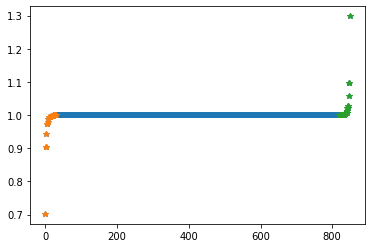

In [31]:
plt.plot(range(len(evals)), sorted(evals) , '*')
plt.plot(range(30), result_[0:30], '*')
plt.plot(range(len(evals)-30, len(evals)), sorted(result_)[30:], '*')

In [ ]:
num = 40, iterates 100 

dim = 80: 0.0001244423053682209
    
dim = 90: 0.00013822053321274004


num = 50, iterates 100 

dim = 100: 8.696922524399758e-05
    


In [53]:
len(result_)

20

In [ ]:
x = np.ones(combined.shape[0])/ np.linalg.norm(np.ones(combined.shape[0]))
rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

print(rho_)

In [47]:
x[0] = -90

In [48]:
xx  = x/np.linalg.norm(x)

In [49]:
rhooo = (xx.T @ mat @ xx)/(xx.T @ mat2 @ xx)
print(rhooo)

0.9997509180289595


In [35]:
dim = 50

for num_ in range(1,25):
    result_1 = []
    for index_ in range(num_):
        x = np.ones(combined.shape[0]) /  np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)
        
    result_2 = []
    for index_ in range(1, num_+1):
        x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 100):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = dim, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)
    result_ = result_1 + result_2 

    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])

    err = (logdet_approx - logdet)/logdet
    print(abs(err))

1.0
0.20783444242705384
0.20783446977734962
0.2702779925095121
0.12980763954996738
0.13468939608705519
0.10143837939748977
0.0512657711400871
0.09539592470946179
0.16913172404906587
0.044188986970387735
0.3253013465417005
0.022936759983317036
0.00901785435733083
0.32310367658004596
0.03611391844490876
0.47919900779849567
0.05752110981361981
0.05849608560376399
0.19081291128986588
0.1511180875030701
0.13457684860266556
0.00797019584872873
0.009153975176927199
0.20551724090396087
0.10683866409159777
0.29690153244758827
0.11641878021143315
0.02848901732263858
0.023944576384217965


KeyboardInterrupt: 

In [40]:
num = 19
result_1 = []
for index_ in range(num):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 60, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[index_]
        v_index = list(evalue).index(evalue[index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_1.append(rho_)

result_2 = []
for index_ in range(1, num+1):
    x = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = 60, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[-index_]
        v_index = list(evalue).index(evalue[-index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_2.append(rho_)

result_ = result_1 + result_2 

logdet_approx = 0
for i in range(len(result_)):
    logdet_approx += np.log(result_[i])
err = (logdet_approx - logdet)/logdet
print(abs(err))

0.0006631627372962413


In [38]:
for i in range(18):
    print(sorted(evals)[i], result_[i])

(0.7021660931758336+0j) 0.7021660931758322
(0.9043124458898861+0j) 0.9043124458898857
(0.9043860910573976+0j) 0.9043860910573961
(0.942193466404906+0j) 0.9421934664049058
(0.9737525286945633+0j) 0.9737525286945633
(0.9737893966140311+0j) 0.9737893966140317
(0.9790931096910711+0j) 0.97909310969107
(0.9791039368998471+0j) 0.979103936899847
(0.9875697482945306+0j) 0.9875697482945321
(0.9932273305554075+0j) 0.9932273305554089
(0.9932346757190679+0j) 0.99323467571907
(0.9939224875522522+0j) 0.9939224875522542
(0.9939376035481406+0j) 0.9939376035481411
(0.9953101015920109+0j) 0.9953101015920114
(0.9953150180428059+0j) 0.9953150180428074
(0.9972053230845186+0j) 0.9972053230845198
(0.998293527348301+0j) 0.9982935273482993
(0.9982974316592799+0j) 0.9982974316592779


In [39]:
for i in range(1,18+1):
    print(sorted(evals)[-i], sorted(result_)[-i])

(1.2978339068241707+0j) 1.2978339068241678
(1.0956875541101154+0j) 1.0956875541101143
(1.0956139089426065+0j) 1.095613908942604
(1.0578065335950946+0j) 1.0578065335950941
(1.0262474713054357+0j) 1.0262474713054368
(1.0262106033859668+0j) 1.0262106033859684
(1.0209068903089304+0j) 1.02090689030893
(1.0208960631001522+0j) 1.020896063100153
(1.0124302517054662+0j) 1.0124302517054677
(1.006772669444588+0j) 1.006772669444591
(1.0067653242809247+0j) 1.00676532428093
(1.0060775124477457+0j) 1.0060775124477457
(1.0060623964518614+0j) 1.006062396451859
(1.0046898984079882+0j) 1.0046898984079886
(1.0046849819571906+0j) 1.0046618635836952
(1.0027946769154785+0j) 1.00279467691548
(1.0017064726517027+0j) 1.0017064726517007
(1.0017025683407246+0j) 1.0017025683407221


In [41]:
for i in range(19):
    print(sorted(evals)[i], result_[i])

(0.7021660931758336+0j) 0.7021660931758322
(0.9043124458898861+0j) 0.9043124458898857
(0.9043860910573976+0j) 0.9043860910573961
(0.942193466404906+0j) 0.9421934664049058
(0.9737525286945633+0j) 0.9737525286945633
(0.9737893966140311+0j) 0.9737893966140317
(0.9790931096910711+0j) 0.97909310969107
(0.9791039368998471+0j) 0.979103936899847
(0.9875697482945306+0j) 0.9875697482945321
(0.9932273305554075+0j) 0.9932273305554089
(0.9932346757190679+0j) 0.99323467571907
(0.9939224875522522+0j) 0.9939224875522542
(0.9939376035481406+0j) 0.9939376035481411
(0.9953101015920109+0j) 0.9953101015920114
(0.9953150180428059+0j) 0.9953150180428074
(0.9972053230845186+0j) 0.9972053230845198
(0.998293527348301+0j) 0.9982935273482993
(0.9982974316592799+0j) 0.9982974316592779
(0.9983927751699344+0j) 0.9984979056085779


In [42]:
for i in range(1,19+1):
    print(sorted(evals)[-i], sorted(result_)[-i])

(1.2978339068241707+0j) 1.2978339068241678
(1.0956875541101154+0j) 1.0956875541101143
(1.0956139089426065+0j) 1.095613908942604
(1.0578065335950946+0j) 1.0578065335950941
(1.0262474713054357+0j) 1.0262474713054368
(1.0262106033859668+0j) 1.0262106033859684
(1.0209068903089304+0j) 1.02090689030893
(1.0208960631001522+0j) 1.020896063100153
(1.0124302517054662+0j) 1.0124302517054677
(1.006772669444588+0j) 1.006772669444591
(1.0067653242809247+0j) 1.00676532428093
(1.0060775124477457+0j) 1.0060775124477457
(1.0060623964518614+0j) 1.006062396451859
(1.0046898984079882+0j) 1.0046898984079886
(1.0046849819571906+0j) 1.0046618635836952
(1.0027946769154785+0j) 1.00279467691548
(1.0017064726517027+0j) 1.0017064726517007
(1.0017025683407246+0j) 1.0017025683407221
(1.0016072248300671+0j) 1.0015920610981452


In [44]:
(logdet_approx - np.log(result_1[-1]) - np.log(result_2[-1]) - logdet)/logdet

8.36570121277453e-05